In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torchvision
import torchaudio
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.datapipes.iter import FileLister
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import os
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import copy
from tqdm import tqdm

In [2]:
train_folder = "../input/birdclef-2022/train_audio"
meta_file_path = "../input/birdclef-2022/train_metadata.csv"

In [3]:
meta_data = pd.read_csv(meta_file_path)

In [4]:
classes = list(meta_data['primary_label'].unique())
print(len(classes))
print(classes)

152
['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'amewig', 'aniani', 'apapan', 'arcter', 'barpet', 'bcnher', 'belkin1', 'bkbplo', 'bknsti', 'bkwpet', 'blkfra', 'blknod', 'bongul', 'brant', 'brnboo', 'brnnod', 'brnowl', 'brtcur', 'bubsan', 'buffle', 'bulpet', 'burpar', 'buwtea', 'cacgoo1', 'calqua', 'cangoo', 'canvas', 'caster1', 'categr', 'chbsan', 'chemun', 'chukar', 'cintea', 'comgal1', 'commyn', 'compea', 'comsan', 'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra', 'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea', 'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo', 'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1', 'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb', 'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow', 'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo', 'mauala', 'maupar', 'merlin', 'mitpar', 'moudov', 'norcar', 'norhar2', 'normoc', 'norpin', 'norsh

In [21]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*10
BATCH_SIZE = 128
EPOCHS = 1
LEARNING_RATE = 0.01
WORKERS = 0
NUM_CLASSES = 152
NUM_FOLDS = 10

In [22]:
!nvidia-smi

Fri Jul  1 20:28:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    33W / 250W |   3217MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
class BirdDataset(Dataset):
    def __init__(self, train_folder, transformation, sample_rate, num_samples, device):
        super().__init__()
        self.device = device
        self.train_files_list = list(FileLister(root=train_folder, recursive=True))
        self.transformation = transformation.to(self.device)
        self.sample_rate = sample_rate
        self.num_samples = num_samples
        
    def __len__(self):
        self.total_train_file = len(self.train_files_list)
        return self.total_train_file
        
    def list_all_files(self):
        return list(self.train_files_list)
    
    def _resample(self, signal, sr):
        if sr != self.sample_rate: 
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_channels(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _right_padding(self,signal):
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_pad = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_pad)
        return signal
        
    def _crop(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
        
    def __getitem__(self,index):
        filename = self.train_files_list[index]
        temp = filename.split(os.sep)
        label = temp[-2]
        label = classes.index(label)
        #label = label.to(self.device)
        signal, sr = torchaudio.load(filename)
        signal = self._resample(signal, sr)
        signal = signal.to(self.device)
        signal = self._mix_channels(signal)
        signal = self._right_padding(signal)
        signal = self._crop(signal)
        signal = self.transformation(signal)
        signal = torch.stack([signal[0],signal[0],signal[0]])
        return signal,label

In [25]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)

In [26]:
bird_cleff_ds = BirdDataset(train_folder, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)

In [27]:
train_loader = DataLoader(bird_cleff_ds, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
dataiter = iter(train_loader)
sample = dataiter.next()
s,l = sample

In [29]:
s.shape

torch.Size([128, 3, 64, 431])

In [30]:
print(l)

tensor([ 39,  28, 131, 102,  72,  30,  12, 124,  68, 150,  68,  68,  45,   7,
         94, 123,  87, 130,  21,  49, 128,  21,  55,  10,  11, 142,  34, 137,
         87, 142,  41,  98,  18,  42,  61,  87, 148,  94,  41,  42, 131,  85,
         10, 148,  94, 109, 141,  45,  38,  50,  45,  41, 142, 129, 102, 118,
         68,  50,  94,  22,  32,  48,  53,  38,  12,  10,  67, 131,  10,  94,
        131,  26, 139,  10,  93,  67, 124,  98,  80,  33, 142,  41, 131,  10,
         39, 151, 137,  87,   8, 122,  16,  51, 131,  22,  10,  58,  42,  87,
        100, 121,  21,  45, 102, 112, 112, 109, 142,  51,  38,  87,  51, 105,
         53, 142, 138,  38, 150, 126,  46,  59, 139, 142,  13,  48,  21, 132,
        102, 131])


In [31]:
def plot_spectrogram(spec, xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10,4))
    axs.set_title("Mel-Spectrogram")
    axs.set_ylabel("mel-freq")
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

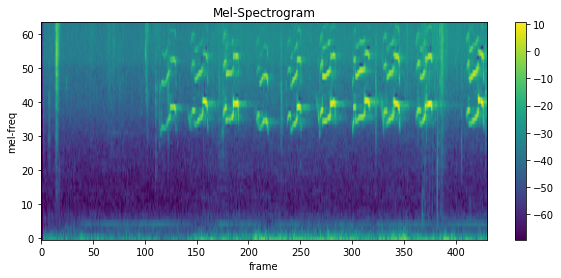

In [32]:
plot_spectrogram(s[3][0].cpu())

In [33]:
def get_model():
    model = models.resnet18(pretrained=True)
    num_ftrs_last_layer = model.fc.in_features
    
    model.fc = nn.Linear(num_ftrs_last_layer, NUM_CLASSES)
    return model

In [34]:
model = get_model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

lr_step_sched = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
folds = StratifiedKFold(n_splits=NUM_FOLDS)

best_model_wts = copy.deepcopy(model.state_dict())

#Train:
for fold, (train_idxs, val_idxs) in enumerate(folds.split(meta_data, meta_data['primary_label'])):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)
    
    train_loader = DataLoader(bird_cleff_ds, batch_size=BATCH_SIZE, sampler=train_subsampler, num_workers=WORKERS)
    val_loader = DataLoader(bird_cleff_ds, batch_size=BATCH_SIZE, sampler=val_subsampler, num_workers=WORKERS)
    
    since = time.time()
    best_acc = 0
    
    
    for epoch in range(EPOCHS):
        for phase in ['train','val']:
            if phase == 'train':
                data_loader = train_loader
                num_samples = len(train_idxs)
                #Set the model into train mode
                model.train()
            else:
                data_loader = val_loader
                num_samples = len(val_idxs)
                #Set the model into eval mode
                model.eval()
                
            runnning_loss = 0.0
            runnning_num_corrects = 0

            #TQDM progress bar
            loop = tqdm(enumerate(data_loader), total=num_samples/BATCH_SIZE, leave=False)
            
            for i, (mel_specs, labels) in loop:
                mel_specs = mel_specs.to(device)
                labels = labels.to(device)
                #print(mel_specs.shape)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(mel_specs)
                    #print(outputs)
                    _, preds = torch.max(outputs,1)
                    
#                     labels_index = []
#                     for j in range(BATCH_SIZE):
#                         labels_index.append(classes.index(labels[j]))
#                     labels_index = torch.tensor(labels_index)
#                     #print(labels_index)
#                     #print(preds)

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                loop.set_description(f"{phase}= Epoch [{epoch}/{EPOCHS}] | Fold [{fold}/{NUM_FOLDS}] ")
                loop.set_postfix(loss = loss.item())
            
                runnning_loss += loss.item()
                runnning_num_corrects += torch.sum(preds == labels)

            if phase == 'train':
                lr_step_sched.step()
            
            epoch_loss = (running_loss * BATCH_SIZE) / num_samples
            epoch_acc = running_corrects.double() / num_samples
            print(f"epoch loss :{epoch_loss} epoch acc :{epoch_acc}")    

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed}")
    print(f"Best accuracy {best_acc}")    

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
train= Epoch [0/1] | Fold [0/10] :  24%|██▍       | 25/104.421875 [10:05<36:07, 27.30s/it, loss=4.6] 

In [52]:
torch.save(model.state_dict(), "bird_cleff_fine_tuned_model.pth")